# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.416892,False,-0.303953
1,0.589605,False,1.360962
2,-1.872921,True,0.010582
3,-0.687083,False,-1.498156
4,-1.003303,True,2.519704
...,...,...,...
995,-1.273668,True,3.952605
996,-2.046190,False,-4.578049
997,-0.124180,False,-0.721190
998,-0.054772,True,5.650987


<AxesSubplot: xlabel='v0'>

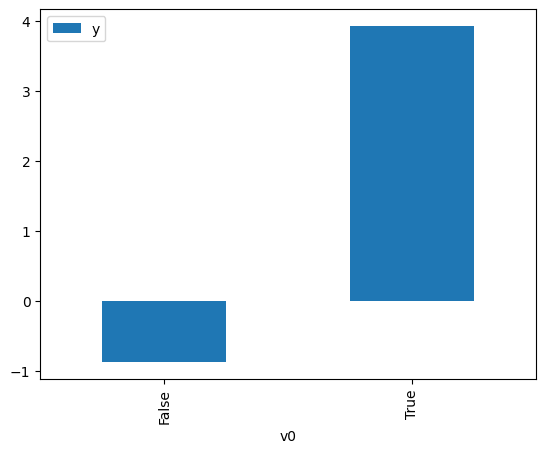

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

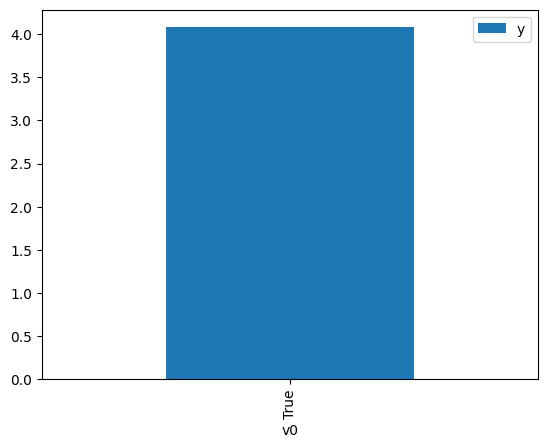

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.175812,False,-2.711317,0.609556,1.640538
1,-0.020282,False,0.362929,0.529505,1.888556
2,-0.184502,False,-2.535766,0.541075,1.848173
3,-1.350229,False,-0.777661,0.621248,1.609664
4,0.197769,False,-1.165499,0.514096,1.945163
...,...,...,...,...,...
995,-2.654519,False,-7.445148,0.703552,1.421359
996,0.950720,False,1.706549,0.460864,2.169839
997,-0.813902,False,-1.716534,0.584905,1.709681
998,-0.295869,False,-0.652319,0.548897,1.821836


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.414105,True,6.374289,0.501219,1.995135
1,-1.591770,True,2.587951,0.362793,2.756391
2,0.586707,True,6.381971,0.513438,1.947656
3,-1.806623,True,0.483721,0.348846,2.866594
4,-0.850839,True,2.887332,0.412558,2.423904
...,...,...,...,...,...
995,-0.242870,True,5.544364,0.454823,2.198658
996,0.583435,True,5.810558,0.513206,1.948534
997,-0.494827,True,4.108218,0.437192,2.287325
998,-1.040138,True,3.239850,0.399627,2.502332


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.926
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              6209.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        19:59:16   Log-Likelihood:                         -1407.3
No. Observations:                1000   AIC:                                      2819.
Df Residuals:                     998   BIC:                                      2828.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8246      0.029     63.547      0.000       1.768       1.881
x2             5.0253      0.049    103.393      0.000       4.930       5.121
==============================================================================
Omnibus:                        1.284   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                1.341
Skew:                           0.055   Prob(JB):                        0.511
Kurtosis:                       2.858   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""